In [7]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import json
from coco_utils import eval_coco
from collections import defaultdict
from tqdm import tqdm

In [8]:
dataset_dir = 'E:/datasets'
dataset_name = 'DOTA_dataset_512'
coco_dir = f'{dataset_dir}/{dataset_name}'
val_coco = f'{coco_dir}/val_coco.json'

# Load the ground truth COCO annotations
cocoGt = COCO(val_coco)

loading annotations into memory...
Done (t=0.75s)
creating index...
index created!


In [9]:
with open(val_coco,'r') as f:
    coco_json = json.load(f)

category_map = {cat['id']:cat['name'] for cat in coco_json['categories']}
categories = list(category_map.keys())

In [27]:
for key, val in category_map.items():
    print(f'{key}:{val}')

1:small-vehicle
2:large-vehicle
3:ship
4:harbor
5:baseball-diamond
6:soccer-ball-field
7:ground-track-field
8:swimming-pool
9:roundabout
10:tennis-court
11:basketball-court
12:plane
13:helicopter
14:bridge
15:storage-tank
16:container-crane


In [10]:
# Load the results (predictions) JSON file
resFile = f'{coco_dir}/YOLO_coco_results_list.json'
cocoDt = cocoGt.loadRes(resFile)

Loading and preparing results...
DONE (t=0.94s)
creating index...
index created!


In [11]:
results = eval_coco(val_coco, resFile, iou_thresh=0.45, conf_thresh=.20)

loading annotations into memory...
Done (t=0.77s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.96s)
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.77s).
Accumulating evaluation results...
DONE (t=0.33s).


In [12]:
for key, val in results.items():
    print(f'{key}:{val}')

1:{'Precision': 0, 'Recall': np.float64(0.0)}
2:{'Precision': 0, 'Recall': np.float64(0.0)}
3:{'Precision': 0, 'Recall': np.float64(0.0)}
4:{'Precision': 0, 'Recall': np.float64(0.0)}
5:{'Precision': 0, 'Recall': np.float64(0.0)}
6:{'Precision': 0, 'Recall': np.float64(0.0)}
7:{'Precision': 0, 'Recall': np.float64(0.0)}
8:{'Precision': np.float64(0.0), 'Recall': np.float64(0.0)}
9:{'Precision': 0, 'Recall': np.float64(0.0)}
10:{'Precision': 0, 'Recall': np.float64(0.0)}
11:{'Precision': 0, 'Recall': np.float64(0.0)}
12:{'Precision': 0, 'Recall': np.float64(0.0)}
13:{'Precision': 0, 'Recall': np.float64(0.0)}
14:{'Precision': 0, 'Recall': np.float64(0.0)}
15:{'Precision': 0, 'Recall': np.float64(0.0)}
16:{'Precision': 0, 'Recall': np.float64(0.0)}


In [20]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

class SilentOutput:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')
    
    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout


def generate_pr_curves_over_conf(val_coco, pred_coco, iou_thresh=0.45, conf_thresholds=np.arange(0.05, 1.0, 0.05)):
    pr_curves = defaultdict(lambda: {'precision': [], 'recall': [], 'conf_thresh': []})
    
    for conf_thresh in tqdm(conf_thresholds):
        # Get precision and recall at the current confidence threshold
        with SilentOutput():
            precision_recall = eval_coco(val_coco, pred_coco, iou_thresh=iou_thresh, conf_thresh=conf_thresh)
        
        for cat_id, pr in precision_recall.items():
            pr_curves[cat_id]['precision'].append(pr['Precision'])
            pr_curves[cat_id]['recall'].append(pr['Recall'])
            pr_curves[cat_id]['conf_thresh'].append(conf_thresh)
    
    return pr_curves

def plot_pr_curves(pr_curves, category_names):
    for cat_id, pr in pr_curves.items():
        plt.figure()
        
        # Extract data
        recalls = pr['recall']
        precisions = pr['precision']
        conf_thresholds = pr['conf_thresh']
        
        # Plot PR curve
        plt.plot(recalls, precisions, marker='o', linestyle='-', color='b')
        
        # Add labels for each point
        for i, conf_thresh in enumerate(conf_thresholds):
            plt.annotate(f'{conf_thresh:.2f}', (recalls[i], precisions[i]), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8)

        # Add title and labels
        plt.title(f'Precision-Recall Curve for Category {category_names[cat_id]}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.grid(True)
        plt.show()

In [22]:
# Generate PR curves data over confidence thresholds
pr_curves = generate_pr_curves_over_conf(val_coco, resFile, 0.45, np.arange(0.00, 1.0, 0.05))



100%|██████████| 20/20 [03:22<00:00, 10.13s/it]


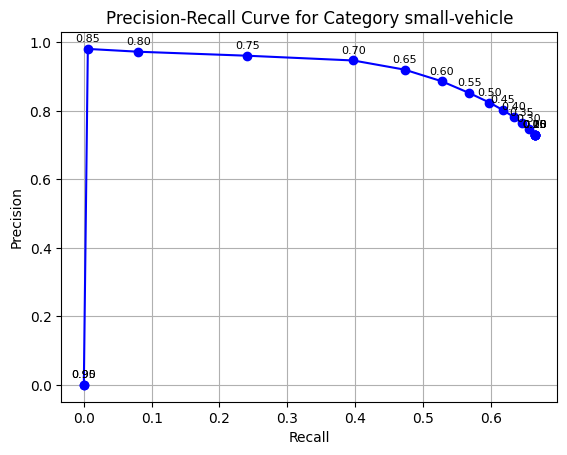

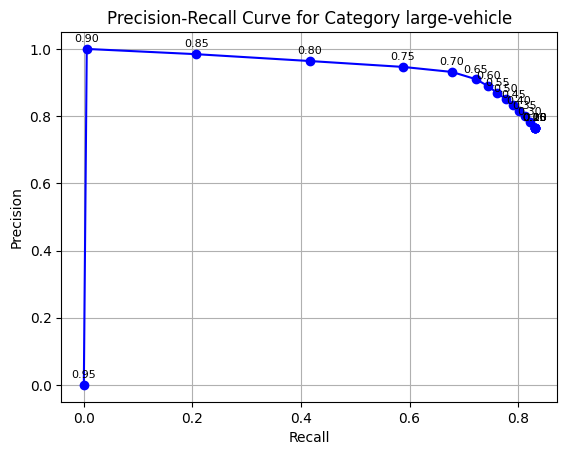

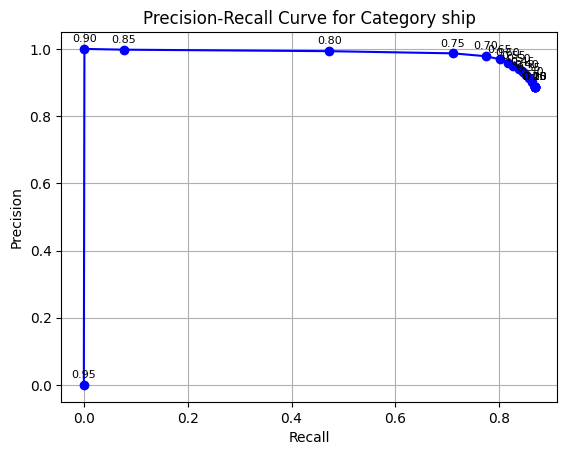

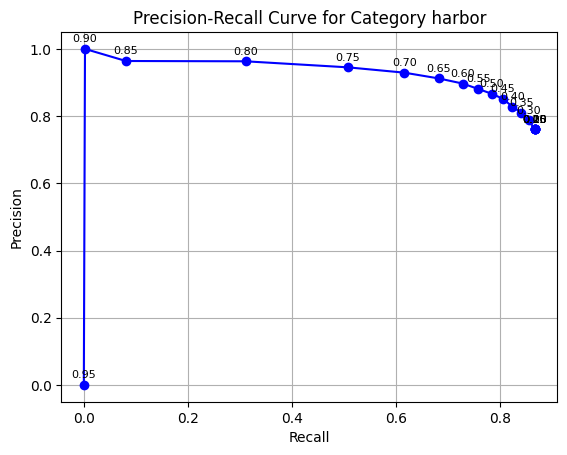

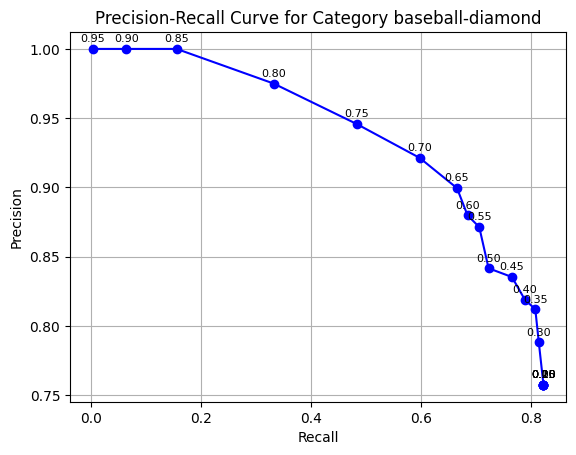

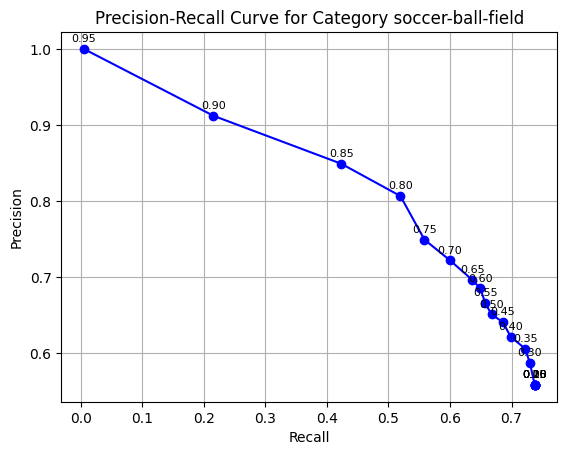

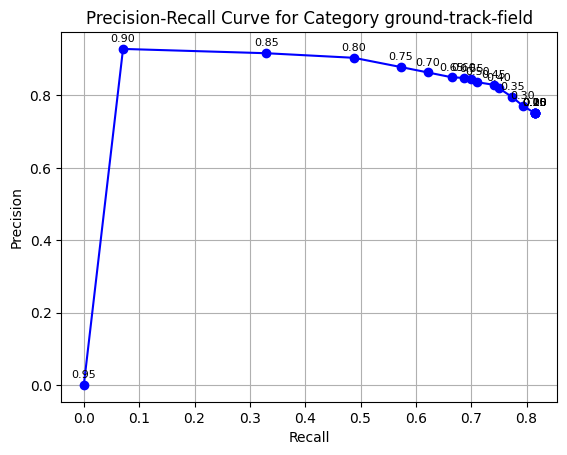

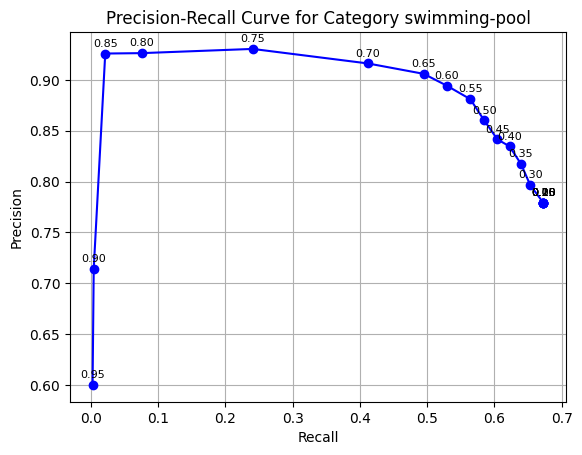

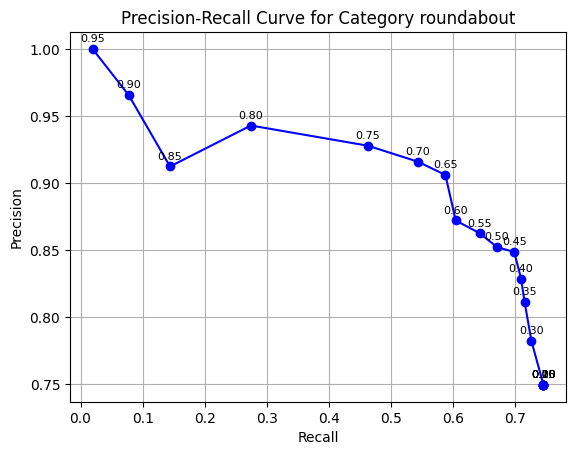

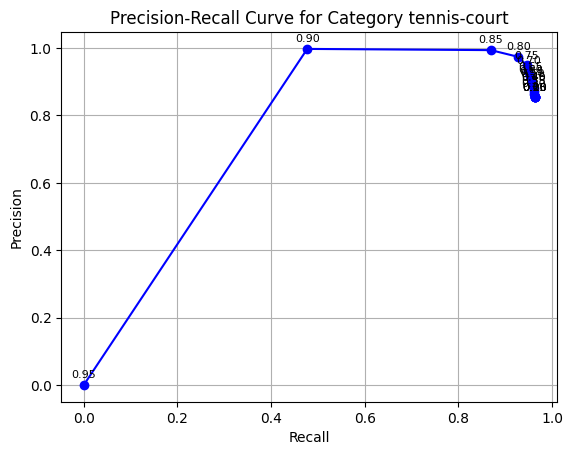

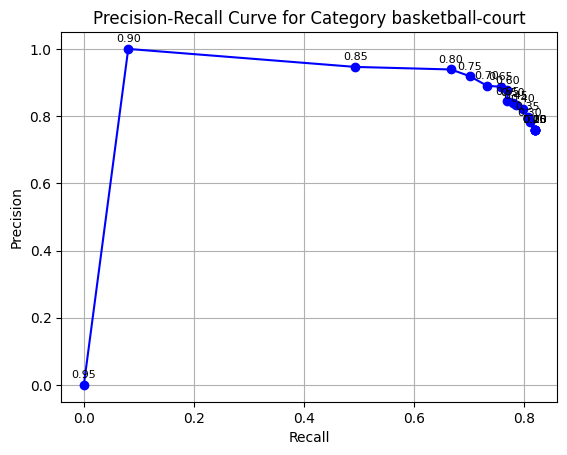

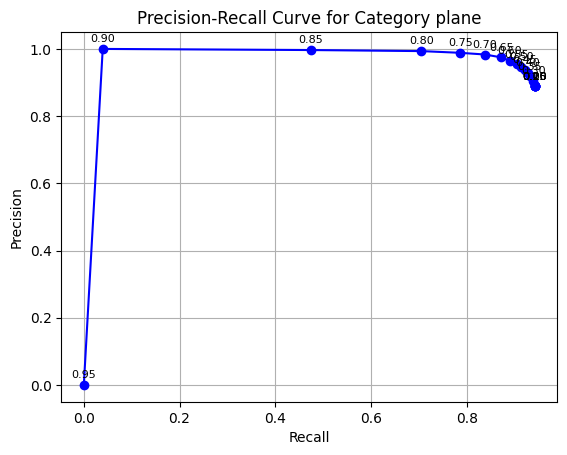

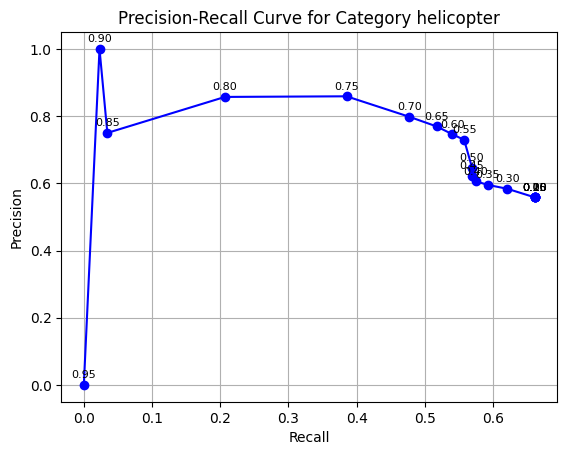

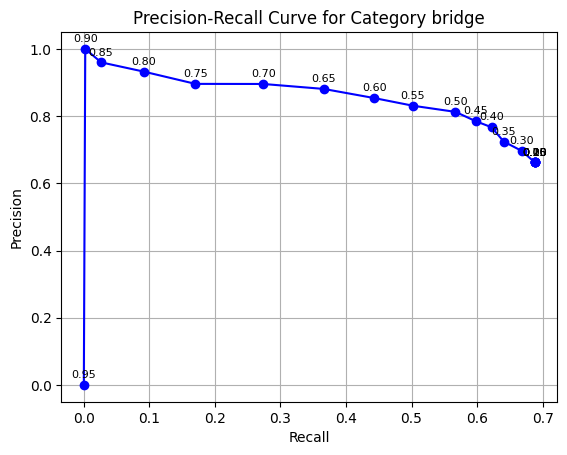

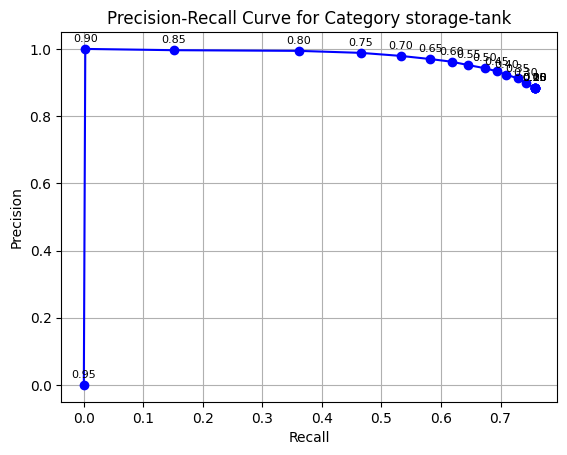

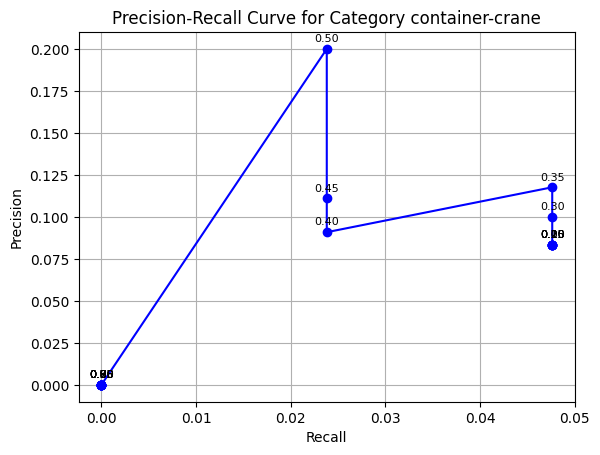

In [23]:
# Plot PR curves
plot_pr_curves(pr_curves, category_map)

In [24]:
def plot_all_curves(pr_curves, category_names):
    plt.figure(figsize=(12, 8))  # Set the figure size
    
    # Define a color map to differentiate curves
    colors = plt.cm.get_cmap('tab10', len(pr_curves))  # 'tab10' colormap with a distinct color for each category

    for cat_id, pr in pr_curves.items():
        # Extract data
        recalls = pr['recall']
        precisions = pr['precision']
        conf_thresholds = pr['conf_thresh']

        # Plot PR curve with a unique color for each category
        plt.plot(recalls, precisions, marker='o', linestyle='-', color=colors(cat_id), label=f'{category_names[cat_id]}')

        # Optionally, add labels for each point
        for i, conf_thresh in enumerate(conf_thresholds):
            plt.annotate(f'{conf_thresh:.2f}', (recalls[i], precisions[i]), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8, color=colors(cat_id))

    # Add title and labels
    plt.title('Precision-Recall Curves for All Categories')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()  # Show the legend with category names
    plt.grid(True)
    plt.show()

C:\Users\neals\AppData\Local\Temp\ipykernel_23956\4291697232.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(pr_curves))  # 'tab10' colormap with a distinct color for each category


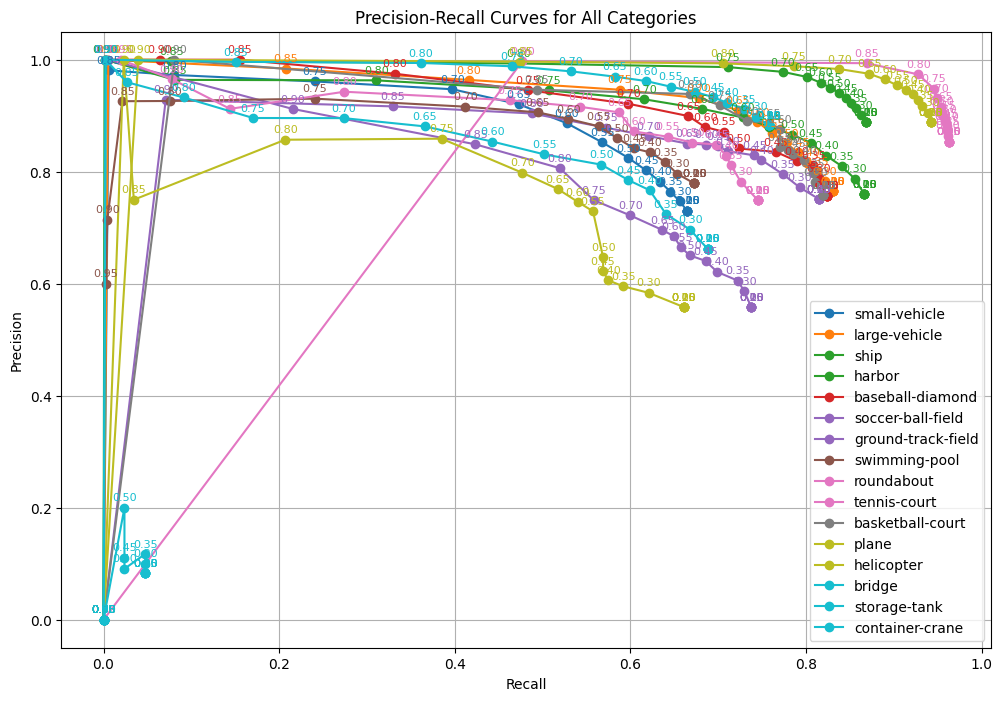

In [25]:
# Plot PR curves
plot_all_curves(pr_curves, category_map)

In [17]:
# Initialize COCOeval object
cocoEval = COCOeval(cocoGt, cocoDt, iouType='bbox')  # iouType can be 'bbox', 'segm', or 'keypoints'

# Evaluate on all categories and images
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

# Optional: Access specific evaluation results
# For example, precision at IoU=0.5, area='all', maxDets=100
precision = cocoEval.eval['precision']
# precision has shape [T, R, K, A, M] where
# T: IoU thresholds, R: recall thresholds, K: number of categories, A: area ranges, M: max detections

print("Precision shape:", precision.shape)

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=56.06s).
Accumulating evaluation results...
DONE (t=1.28s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.426
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.681
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.465
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.313
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.439
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.528
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.228
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.428
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.496
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.351
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=10

In [18]:
cocoEval.params.catIds

[np.int64(1),
 np.int64(2),
 np.int64(3),
 np.int64(4),
 np.int64(5),
 np.int64(6),
 np.int64(7),
 np.int64(8),
 np.int64(9),
 np.int64(10),
 np.int64(11),
 np.int64(12),
 np.int64(13),
 np.int64(14),
 np.int64(15),
 np.int64(16)]

In [19]:
ap_per_class = {}
for i, cat_id in enumerate(categories):
    # Select precision values for this category (Kth index in the precision array)
    precision = cocoEval.eval['precision'][:, :, i, 0, -1]  # T, R, K, A, M
    
    # Compute AP by averaging precision across IoU thresholds and recall levels
    ap = precision.mean()  # Mean over IoU thresholds and recall levels
    
    cat_name = category_map[i+1]
    ap_per_class[cat_name] = ap
    print(f"Category: {cat_name}, AP: {ap:.4f}")

Category: small-vehicle, AP: 0.2790
Category: large-vehicle, AP: 0.5043
Category: ship, AP: 0.5218
Category: harbor, AP: 0.4009
Category: baseball-diamond, AP: 0.4859
Category: soccer-ball-field, AP: 0.4598
Category: ground-track-field, AP: 0.4971
Category: swimming-pool, AP: 0.2647
Category: roundabout, AP: 0.4125
Category: tennis-court, AP: 0.7263
Category: basketball-court, AP: 0.5842
Category: plane, AP: 0.6708
Category: helicopter, AP: 0.2956
Category: bridge, AP: 0.2576
Category: storage-tank, AP: 0.4413
Category: container-crane, AP: 0.0078
